DQN Training: 100%|██████████| 1000/1000 [01:10<00:00, 14.19it/s, cost=2520.0, eps=0.967]


len(cost_tab) = 1000
len(cost_dqn) = 1000


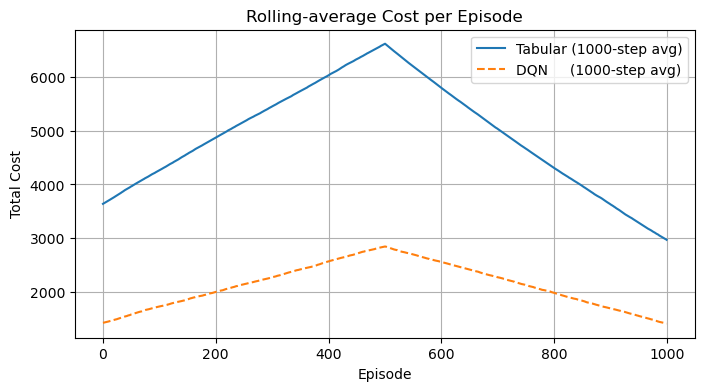

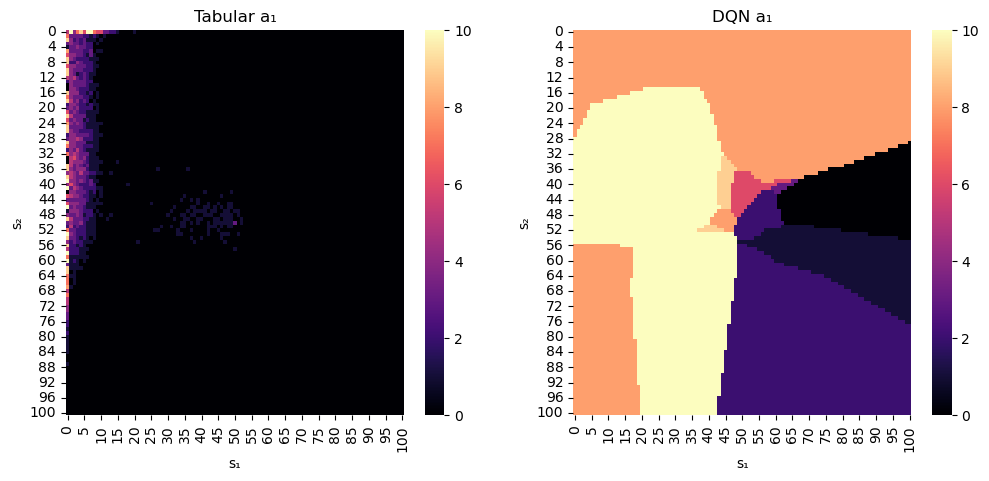

/tmp/ipykernel_11680/1594616307.py:246: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([costs_tab, costs_dqn], labels=["Tabular","DQN"])


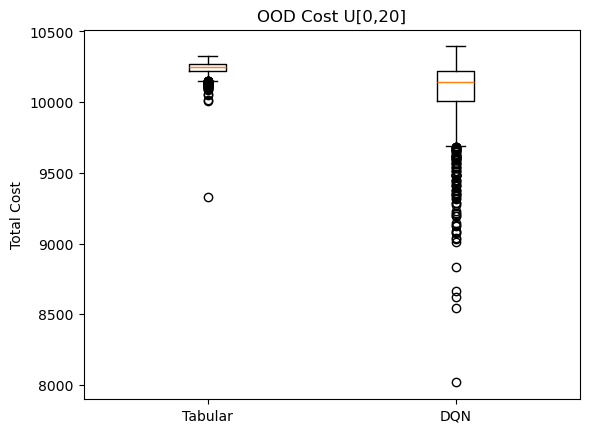

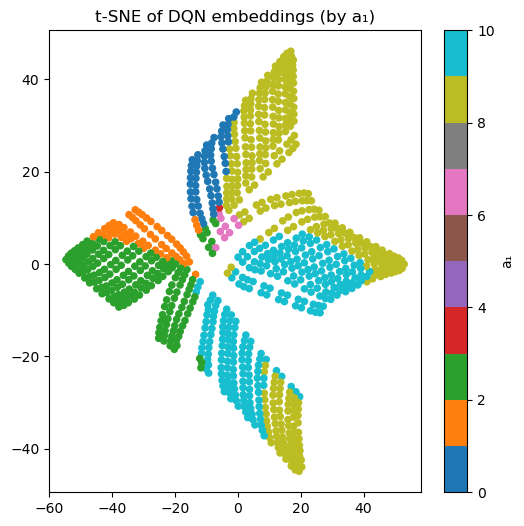

In [8]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange
from sklearn.manifold import TSNE
import seaborn as sns
import imageio
import os
import shutil

# -----------------------
# 1) MULTI‐PRODUCT ENV
# -----------------------
class TwoProductEnv:
    def __init__(self, min_inv=-50, max_inv=50, horizon=50, U_max=10, demand_range=(0,10)):
        self.min_inv, self.max_inv = min_inv, max_inv
        self.horizon = horizon
        self.U_max   = U_max
        self.d_low, self.d_high = demand_range

    def reset(self):
        self.s = np.array([0,0], dtype=int)
        self.t = 0
        return self._obs()

    def step(self, a):
        w1 = random.randint(self.d_low, self.d_high)
        w2 = random.randint(self.d_low, self.d_high)
        s2 = self.s + np.array(a) - np.array([w1,w2])
        s2 = np.clip(s2, self.min_inv, self.max_inv)

        p, h, b = 1.0, 1.0, 2.0
        cost = p*(a[0]+a[1]) + (h*max(s2[0],0) + b*max(-s2[0],0)) \
                            + (h*max(s2[1],0) + b*max(-s2[1],0))

        self.s = s2
        self.t += 1
        done = (self.t >= self.horizon)
        return self._obs(), cost, done

    def _obs(self):
        return np.array([self.s[0], self.s[1]], dtype=int)


# -----------------------
# 2) TABULAR Q‐LEARNING
# -----------------------
def train_tabular(env, episodes=200_000, alpha=0.1, eps=0.1, gamma=1.0):
    S = env.max_inv - env.min_inv + 1
    U = env.U_max + 1
    Q = np.zeros((S, S, U*U), dtype=np.float32)
    cost_hist = []
    pbar = trange(episodes, desc="Tabular Q")
    for ep in pbar:
        obs = env.reset()
        total_cost = 0.0
        done = False
        while not done:
            s1,s2 = obs; i1 = s1 - env.min_inv; i2 = s2 - env.min_inv
            if random.random() < eps:
                a_idx = random.randrange(U*U)
            else:
                a_idx = int(np.argmin(Q[i1,i2,:]))
            a1, a2 = divmod(a_idx, U)
            obs2, cost, done = env.step((a1,a2))
            total_cost += cost
            if done:
                target = cost
            else:
                j1,j2 = obs2 - env.min_inv
                target = cost + gamma * np.min(Q[j1,j2,:])
            Q[i1,i2,a_idx] += alpha * (target - Q[i1,i2,a_idx])
            obs = obs2
        cost_hist.append(total_cost)
        pbar.set_postfix(cost=f"{total_cost:.1f}")
    pi_tab = np.zeros((S, S, 2), dtype=int)
    for i1 in range(S):
        for i2 in range(S):
            best = int(np.argmin(Q[i1,i2,:]))
            pi_tab[i1,i2,:] = [best//U, best%U]
    return pi_tab, cost_hist


# -----------------------
# 3) DQN AGENT
# -----------------------
class DQNNet(nn.Module):
    def __init__(self, state_dim, U):
        super().__init__()
        A = (U+1)**2
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128),       nn.ReLU(),
            nn.Linear(128, A)
        )
    def forward(self,x):
        return self.net(x)

def train_dqn(env,
              episodes=100_000,
              buffer_size=50_000,
              batch_size=64,
              gamma=0.99,
              lr=1e-3,
              eps_start=1.0,
              eps_end=0.05,
              eps_decay=30_000,
              target_sync=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = DQNNet(2, env.U_max).to(device)
    tgt = DQNNet(2, env.U_max).to(device)
    tgt.load_state_dict(net.state_dict())
    opt = optim.Adam(net.parameters(), lr=lr)
    buf = deque(maxlen=buffer_size)
    mse = nn.MSELoss()
    cost_hist = []
    steps = 0
    eps = eps_start

    def normalize(s):
        arr = np.array(s, dtype=np.float32)
        return (arr - env.min_inv)/(env.max_inv-env.min_inv)*2 - 1

    pbar = trange(episodes, desc="DQN Training")
    for ep in pbar:
        obs = env.reset()
        total_cost = 0.0
        done = False
        while not done:
            s_norm = torch.FloatTensor(normalize(obs)).unsqueeze(0).to(device)
            if random.random() < eps:
                a_idx = random.randrange((env.U_max+1)**2)
            else:
                with torch.no_grad():
                    q = net(s_norm)
                    a_idx = int(q.argmin(dim=1).item())
            a1, a2 = divmod(a_idx, env.U_max+1)
            obs2, cost, done = env.step((a1,a2))
            total_cost += cost
            buf.append((obs, a_idx, cost, obs2, done))
            obs = obs2

            if len(buf) >= batch_size:
                batch = random.sample(buf, batch_size)
                s_b,a_b,c_b,s2_b,d_b = zip(*batch)
                s_v  = torch.FloatTensor([normalize(s) for s in s_b]).to(device)
                a_v  = torch.LongTensor(a_b).to(device)
                c_v  = torch.FloatTensor(c_b).to(device)
                s2_v = torch.FloatTensor([normalize(s2) for s2 in s2_b]).to(device)
                d_v  = torch.FloatTensor(d_b).to(device)

                q_vals = net(s_v).gather(1,a_v.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    q2    = tgt(s2_v)
                    q2min = q2.min(dim=1)[0]
                    target= c_v + gamma * q2min * (1-d_v)
                loss = mse(q_vals, target)
                opt.zero_grad(); loss.backward(); opt.step()

                steps += 1
                if steps % target_sync == 0:
                    tgt.load_state_dict(net.state_dict())

        cost_hist.append(total_cost)
        eps = max(eps_end, eps * np.exp(-1/eps_decay))
        pbar.set_postfix(cost=f"{total_cost:.1f}", eps=f"{eps:.3f}")

    # extract policy
    net.eval()
    S = env.max_inv - env.min_inv + 1
    pi_dqn = np.zeros((S,S,2), dtype=int)
    with torch.no_grad():
        for i1,s1 in enumerate(range(env.min_inv, env.max_inv+1)):
            for i2,s2 in enumerate(range(env.min_inv, env.max_inv+1)):
                s_norm = torch.FloatTensor(normalize([s1,s2])).unsqueeze(0).to(device)
                q      = net(s_norm)[0].detach().cpu().numpy()  # <-- detach()
                a_idx  = int(np.argmin(q))
                pi_dqn[i1,i2,:] = [a_idx//(env.U_max+1), a_idx%(env.U_max+1)]
    return pi_dqn, cost_hist, net.to(device)


# -----------------------
# 4) RUN & PLOT
# -----------------------
if __name__ == "__main__":
    env = TwoProductEnv(min_inv=-50, max_inv=50, horizon=50, U_max=10, demand_range=(0,10))

    # 1) Train Tabular & DQN
    pi_tab, cost_tab = train_tabular(env, episodes=1000)
    pi_dqn, cost_dqn, net = train_dqn(env, episodes=1000)

    print("len(cost_tab) =", len(cost_tab))
print("len(cost_dqn) =", len(cost_dqn))

# if you really want a 1 000-step rolling average but have fewer episodes,
# clamp it:
window = min(1000, len(cost_tab))
if window < 2:
    print("Not enough episodes to compute a rolling average.")
else:
    rt_tab = np.convolve(cost_tab, np.ones(window)/window, mode="same")
    rt_dqn = np.convolve(cost_dqn, np.ones(window)/window, mode="same")

    plt.figure(figsize=(8,4))
    plt.plot(rt_tab,  label="Tabular ({}-step avg)".format(window))
    plt.plot(rt_dqn, '--', label="DQN     ({}-step avg)".format(window))
    plt.xlabel("Episode")
    plt.ylabel("Total Cost")
    plt.title("Rolling-average Cost per Episode")
    plt.legend()
    plt.grid(True)
    plt.show()


    # 3) Coupling heatmaps for product 1
    S = env.max_inv - env.min_inv + 1
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    sns.heatmap(pi_tab[:,:,0].T, cmap="magma", ax=axes[0])
    axes[0].set(title="Tabular a₁", xlabel="s₁", ylabel="s₂")
    sns.heatmap(pi_dqn[:,:,0].T, cmap="magma", ax=axes[1])
    axes[1].set(title="DQN a₁", xlabel="s₁", ylabel="s₂")
    plt.show()

    # 4) OOD box‐plot
    def test_policy(pi, env, demand=(0,20), trials=2000):
        orig = env.d_low, env.d_high
        env.d_low, env.d_high = demand
        results=[]
        for _ in range(trials):
            s = np.array([0,0],int)
            tot=0
            for _ in range(env.horizon):
                a1,a2 = pi[s[0]-env.min_inv, s[1]-env.min_inv]
                _,c,_ = env.step((a1,a2))
                tot += c
            results.append(tot)
        env.d_low, env.d_high = orig
        return results

    costs_tab = test_policy(pi_tab, env)
    costs_dqn= test_policy(pi_dqn, env)
    plt.boxplot([costs_tab, costs_dqn], labels=["Tabular","DQN"])
    plt.title("OOD Cost U[0,20]"); plt.ylabel("Total Cost"); plt.show()

    # 5) t-SNE embedding of DQN hidden layer
    device = next(net.parameters()).device
    def get_embedding(x):
        with torch.no_grad():
            return net.net[:4](x).cpu().numpy()

    states, actions = [], []
    for s1 in np.linspace(env.min_inv, env.max_inv, 30, dtype=int):
        for s2 in np.linspace(env.min_inv, env.max_inv, 30, dtype=int):
            norm = (np.array([s1,s2],np.float32)-env.min_inv)/(env.max_inv-env.min_inv)*2-1
            x = torch.FloatTensor(norm).unsqueeze(0).to(device)
            with torch.no_grad():
                q = net(x)[0].detach().cpu().numpy()    # <-- detach() here too
            a_idx = int(np.argmin(q))
            states.append(norm)
            actions.append(a_idx//(env.U_max+1))

    emb = get_embedding(torch.FloatTensor(states).to(device))
    tsne = TSNE(n_components=2, random_state=0).fit_transform(emb)
    plt.figure(figsize=(6,6))
    sc = plt.scatter(tsne[:,0], tsne[:,1], c=actions, cmap="tab10", s=20)
    plt.title("t-SNE of DQN embeddings (by a₁)"); plt.colorbar(sc,label="a₁"); plt.show()
